In [5]:
!pip install datasets umap-learn
try:
    import datasets
    from umap import UMAP
except ImportError:
    !pip install datasets umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibi

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import ClassLabel, Dataset, DatasetDict, Features, Value
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from umap import UMAP
from huggingface_hub import notebook_login
import seaborn as sns

(8695, 2)
       label                                               text
0    Biology  A few things. You might have negative- frequen...
1    Physics  Is it so hard to believe that there exist part...
2    Biology                                     There are bees
3    Biology  I'm a medication technician. And that's alot o...
4  Chemistry                     Cesium is such a pretty metal.
Atributos do Dataset: Index(['label', 'text'], dtype='object')


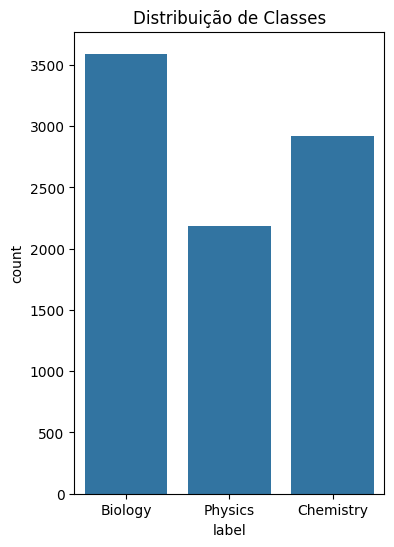

In [9]:
import pandas as pd

df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")
df = pd.concat([df1, df2], axis=0)

# Reset the index
df.reset_index(drop=True, inplace=True)

def display_attributes(df):
    print(df.shape)
    print(df.head(5))
    print("Atributos do Dataset:", df.columns)

def display_head(df, n=5):
    return df.head(n)

def plot_class_distribution(df):
    plt.figure(figsize=(4, 6))
    sns.countplot(x='label', data=df)
    plt.title("Distribuição de Classes")
    plt.show()

# Exemplo de uso
dataset = df1.rename(columns={'Comment': 'text', 'Topic': 'label'})
dataset = dataset[['label', 'text']]
dataset = dataset.dropna()
dataset.reset_index(drop=True, inplace=True)
dataset.shape
display_attributes(dataset)
plot_class_distribution(dataset)




In [10]:
attributes = dataset.columns.tolist()
print("Atributos do Dataset:")
for attribute in attributes:
    print("-", attribute)

classes = dataset['label'].unique()
print("\nClasses de Classificação (label):")
for class_label in classes:
    print("-", class_label)

Atributos do Dataset:
- label
- text

Classes de Classificação (label):
- Biology
- Physics
- Chemistry


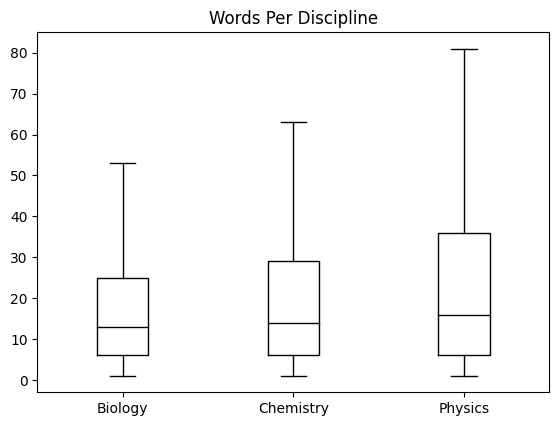

In [11]:
dataset["Words Per Discipline"] = dataset["text"].str.split().apply(len)
dataset.boxplot("Words Per Discipline", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()


In [12]:
df = df[['Comment', 'Topic']]
df = df.rename(columns={'Comment': 'text', 'Topic': 'label'})

In [13]:
df

,text,label
0,A few things. You might have negative- frequen...,Biology
1,Is it so hard to believe that there exist part...,Physics
2,There are bees,Biology
3,I'm a medication technician. And that's alot o...,Biology
4,Cesium is such a pretty metal.,Chemistry
...,...,...
10276,I’m not really denying your intent. I’m a) dou...,Chemistry
10277,i really empathize with your compassion for bu...,Biology
10278,"If you want to keep it for more than 2 weeks, ...",Chemistry
10279,Same here. I’m in nursing school so I only hav...,Biology


In [14]:
from datasets import ClassLabel, Features, Value
features = Features({
    'text': Value(dtype='string'),
    'label': ClassLabel(names=['Biology','Chemistry', 'Physics'])
})
df['label'] = df['label'].astype('category').cat.codes
df.dtypes

,0
text,object
label,int8


In [15]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[['text', 'label']], features=features)
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 10281
})

In [16]:
from datasets import DatasetDict
train_test_split = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

validation_test_split = train_test_split['test'].train_test_split(test_size=0.5, shuffle=True, seed=42)

dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': validation_test_split['train'],
    'test': validation_test_split['test']
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8224
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1028
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1029
    })
})

In [17]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,A few things. You might have negative- frequen...,0,Biology
1,Is it so hard to believe that there exist part...,2,Physics
2,There are bees,0,Biology
3,I'm a medication technician. And that's alot o...,0,Biology
4,Cesium is such a pretty metal.,1,Chemistry


In [18]:
train_ds = dataset["train"]
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['Biology', 'Chemistry', 'Physics'], id=None)}

In [19]:
from transformers import AutoModel, AutoTokenizer
import torch

model_ckpt = "j-hartmann/sentiment-roberta-large-english-3-classes"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

In [20]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")

In [21]:
model_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/8224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [22]:
model_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [23]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # clear CUDA cache
    torch.cuda.empty_cache()
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [24]:
model_hidden = model_encoded.map(extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/8224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [25]:
X_train = np.array(model_hidden["train"]["hidden_state"])
X_valid = np.array(model_hidden["validation"]["hidden_state"])
y_train = np.array(model_hidden["train"]["label"])
y_valid = np.array(model_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((8224, 1024), (1028, 1024))

In [26]:
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,8.165921,5.598048,1
1,6.973209,6.015811,2
2,12.342987,-4.626617,1
3,4.200340,7.000130,0
4,3.763014,8.795361,2


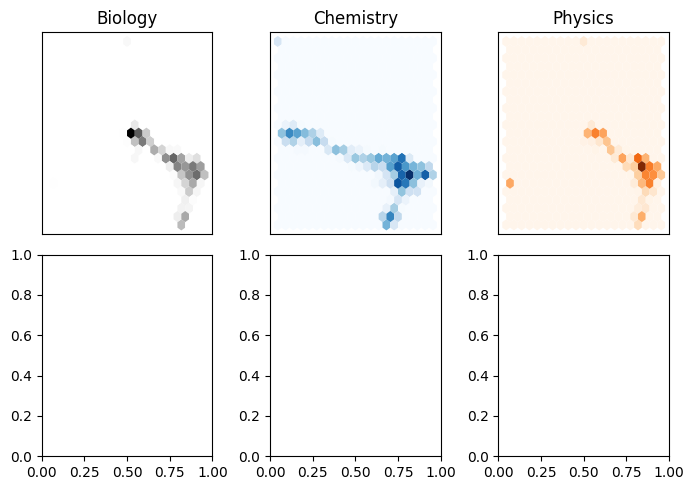

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Greens", "Purples"]
labels = dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [28]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

lr_clf.score(X_valid, y_valid)

0.646887159533074

In [29]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.4095330739299611

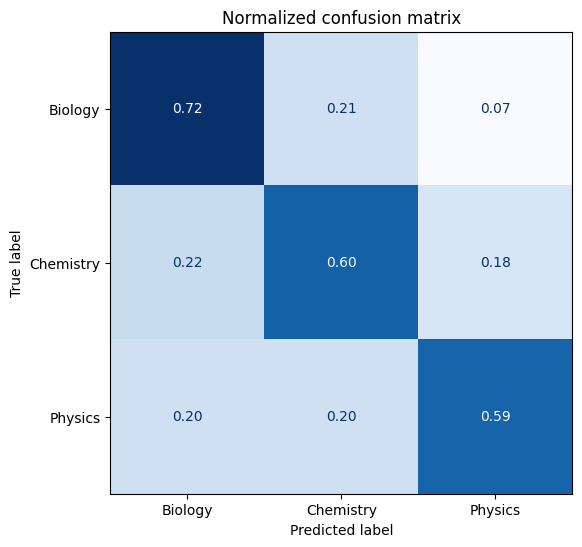

In [30]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [31]:
num_labels = 3
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels, ignore_mismatched_sizes=True)
         .to(device))

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [54]:
batch_size = 4
logging_steps = len(model_encoded["train"]) // batch_size
model_name = f"{model_ckpt}_bs{batch_size}"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [53]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=model_encoded["train"],
                  eval_dataset=model_encoded["validation"],
                  tokenizer=tokenizer

)
trainer.train();

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 75.06 MiB is free. Process 5156 has 14.67 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 23.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [49]:
preds_output = trainer.predict(model_encoded["validation"])
preds_output.metrics

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 73.06 MiB is free. Process 5156 has 14.67 GiB memory in use. Of the allocated memory 14.41 GiB is allocated by PyTorch, and 140.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)